In [1]:
import matplotlib.pyplot as plt
import os

from dask.distributed import Client
from dask_cuda import LocalCUDACluster

from ase.build import bulk
from abtem import show_atoms, FrozenPhonons, Probe, Potential, GridScan, AnnularDetector

Runtime: 8 s per frozen phonon on 1 NVidia RTX 2080 Ti

In [2]:
cluster = LocalCUDACluster(memory_limit='10gb', n_workers=1)
client = Client(cluster)

C:\Users\jacob\anaconda3\envs\abtem-dask-gpu\lib\site-packages\distributed\node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 55853 instead
  warnings.warn(
C:\Users\jacob\anaconda3\envs\abtem-dask-gpu\lib\site-packages\dask_cuda\utils.py:168: UserWarning: Cannot get CPU affinity for device with index 0, setting default affinity
  warnings.warn(


In [3]:
client

Client Scheduler: tcp://127.0.0.1:55854 Dashboard: http://127.0.0.1:55853/status,Cluster Workers: 1 Cores: 1 Memory: 9.31 GiB


In [4]:
atoms = bulk('Si', 'diamond', a=5.43, cubic=True)
atoms *= (2, 2, 20)

In [7]:
chunks = 800 # max number of wave functions in each chunk (use large chunks on GPU)

frozen_phonons = FrozenPhonons(atoms, 4, {'Si': .1})

potential = Potential(frozen_phonons, 
                      gpts=512, 
                      device='gpu', 
                      projection='infinite', 
                      slice_thickness=1)

probe = Probe(energy=100e3, semiangle_cutoff=20, device='gpu')

scan = GridScan()

detectors = AnnularDetector(50, 150, to_cpu=True)

measurement = probe.scan(scan, detectors, potential, chunks=chunks, lazy=True)

In [8]:
probe.build(scan, chunks).array # For showing the size of the chunks

dask.array<calculate_probes, shape=(27, 27, 512, 512), dtype=complex64, chunksize=(27, 27, 512, 512), chunktype=numpy.ndarray>

In [9]:
%%time
measurement.compute()

Wall time: 33.2 s


(<AxesSubplot:xlabel='x [Å]', ylabel='y [Å]'>,
 <matplotlib.image.AxesImage at 0x1f5b3c4bc70>)

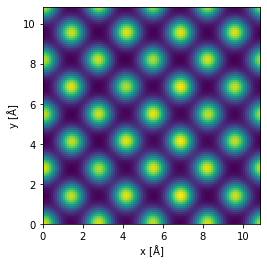

In [11]:
measurement.interpolate(.1).show()